In [1]:
import copy
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

# lenstronomy module import
import lenstronomy.Util.data_util as data_util
import lenstronomy.Util.util as util
import lenstronomy.Plots.plot_util as plot_util
from lenstronomy.SimulationAPI.sim_api import SimAPI

## loading PSFs

In [2]:
from astropy.io import fits
import lenstronomy.Util.kernel_util as kernel_util

#f160w_psf = fits.getdata('psf/wfc3_f160w00_psf.fits')
f160w_psf_hires = fits.getdata('psf/wfc3_f160w_hires00_psf.fits')
f200lp_psf = fits.getdata('psf/wfc3_200lp00_psf.fits')

f160w_psf = kernel_util.degrade_kernel(f160w_psf_hires, degrading_factor=3)[1:62, 1:62]

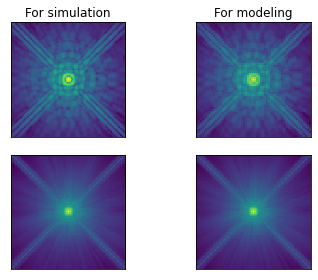

In [3]:
simulation_psfs = [f160w_psf_hires, f200lp_psf]
modeling_psfs = [f160w_psf, f200lp_psf]

fig, axes = plt.subplots(ncols=2, nrows=len(simulation_psfs))

for i in range(len(simulation_psfs)):
    axes[i, 0].matshow(np.log10(simulation_psfs[i]))
    axes[i, 1].matshow(np.log10(modeling_psfs[i]))
    
    axes[i, 0].set_xticks([])
    axes[i, 0].set_yticks([])
    axes[i, 1].set_xticks([])
    axes[i, 1].set_yticks([])
    
axes[0, 0].set_title('For simulation')
axes[0, 1].set_title('For modeling')

fig.tight_layout()

In [4]:
lens_specifications = {
    'num_lenses': 5,
    'with_quasar': False
}


# Specify the filter and detector characteristics
# the values here correspond to WFC3 F140W and F200LP
filter_specifications = {
    'read_noise': [14, 3],
    # https://www.stsci.edu/itt/review/ihb_cy18/WFC3/c05_detector8.html#358383
    # https://www.stsci.edu/files/live/sites/www/files/home/hst/instrumentation/wfc3/documentation/instrument-science-reports-isrs/_documents/2015/WFC3-2015-13.pdf
    
    'ccd_gain': [1., 1.5],
    
    'sky_brightness': [
        -2.5 * np.log10(1.93e-18 * 3.34e4 *  14000**2 / 3631), # F140W
        -2.5 * np.log10(7.72e-18 * 3.34e4 *  5500**2 / 3631), # F200LP
    ],
    
    'magnitude_zero_point': [26.450, 27.336], 
    # https://www.stsci.edu/hst/instrumentation/wfc3/data-analysis/photometric-calibration/ir-photometric-calibration
    # https://www.stsci.edu/hst/instrumentation/wfc3/data-analysis/photometric-calibration/uvis-photometric-calibration
    
    'seeing': [None, None],
    'pixel_scale': [0.08, 0.04],
    'num_pixel': [60, 120],
    'simulation_psf_supersampling_resolution': [3, 1],
    'modeling_psf_supersampling_resolution': [1, 1],
    'simulation_shapelet_n_max': [50, 50], # higher n_max allows more structure, max is 15
    'modeling_shapelet_n_max': [4, 8], # higher n_max allows more structure, max is 15
}

# different observing scenarios
# must include exposure_times and num_exposures for each filter
observing_scenarios = [
    # scenario 1
    {'exposure_time': [300, 300], # exposure time per frame
     'num_exposure': [3, 1],  # number of exposures to combine
     'simulate_cosmic_ray': [1.2e-3, 2.4e-3] # bool (default hit count: 2.4e-3/arcsec^2/s), or CR hit count / arcsec^2 / s
     # whether to simulate cosmic ray hits, will randomly create weighted exposure time map
     # if single exposure, then pixels hit by cosmic ray will be masked

    },
    
    # scenario 2
    {'exposure_time': [300, 300], 
     'num_exposure': [2, 2], 
     'simulate_cosmic_ray': [1.2e-3, 2.4e-3]
    },
    
    # scenario 3
    {'exposure_time': [200, 300], 
     'num_exposure': [3, 2], 
     'simulate_cosmic_ray': [1.2e-3, 2.4e-3]
    },
]


# dictionary containing PSFs
psfs = {
    'simulation': simulation_psfs,
    'modeling': modeling_psfs
}

In [5]:
from scipy import stats

# distribution function for lens and source magnitudes
lens_magnitude_distributions = lambda: np.random.normal(18.5, 0.15) + np.array([0, np.random.normal(2.7, .2)])

source_magnitude_distributions = lambda: np.random.normal(20.8, 0.08) + np.array([0., np.random.normal(2., .2)])

quasar_magnitude_distributions = lambda: np.random.uniform(20, 21) + np.array([0., np.random.uniform(0.5, 1.2)])

magnitude_distributions = {
    'lens': lens_magnitude_distributions,
    'source': source_magnitude_distributions,
    'quasar': quasar_magnitude_distributions
}

## simulate data

In [6]:
from simulator import Simulator

simulator = Simulator(lens_specifications, filter_specifications, observing_scenarios,
                      psfs, magnitude_distributions, use_pemd=False, 
                      source_galaxy_indices=[40, 30, 8, 15, 34, 21, 19, 25, 69, 2, 53, 78])
    

C:\Users\Anowar\Dropbox\Lensing exposure time calculator\simulator.py:198: RuntimeWarning: invalid value encountered in log10
  np.log10(self.simulated_data[j][n][i]),


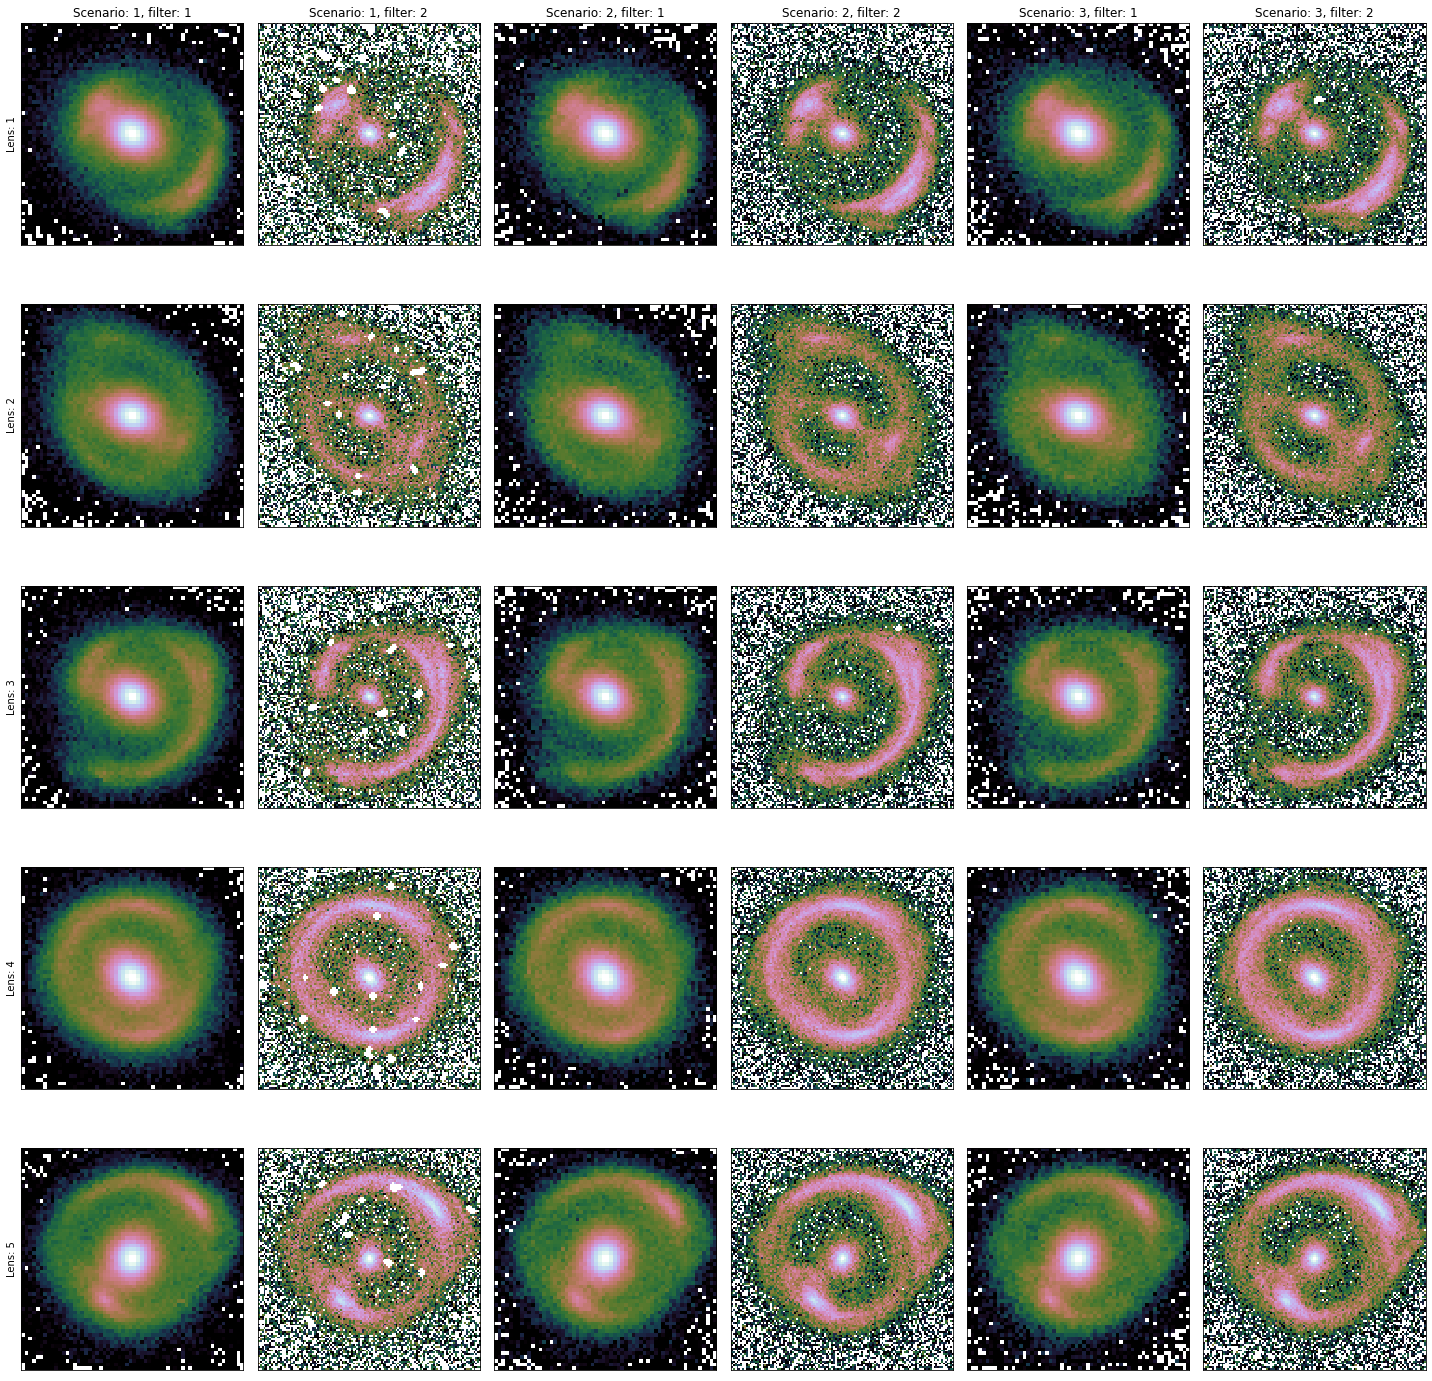

In [7]:
%matplotlib inline

simulator.plot_simualated_data(vmin=[-1, -2], vmax=[1, 0], figsize=(20, 20))

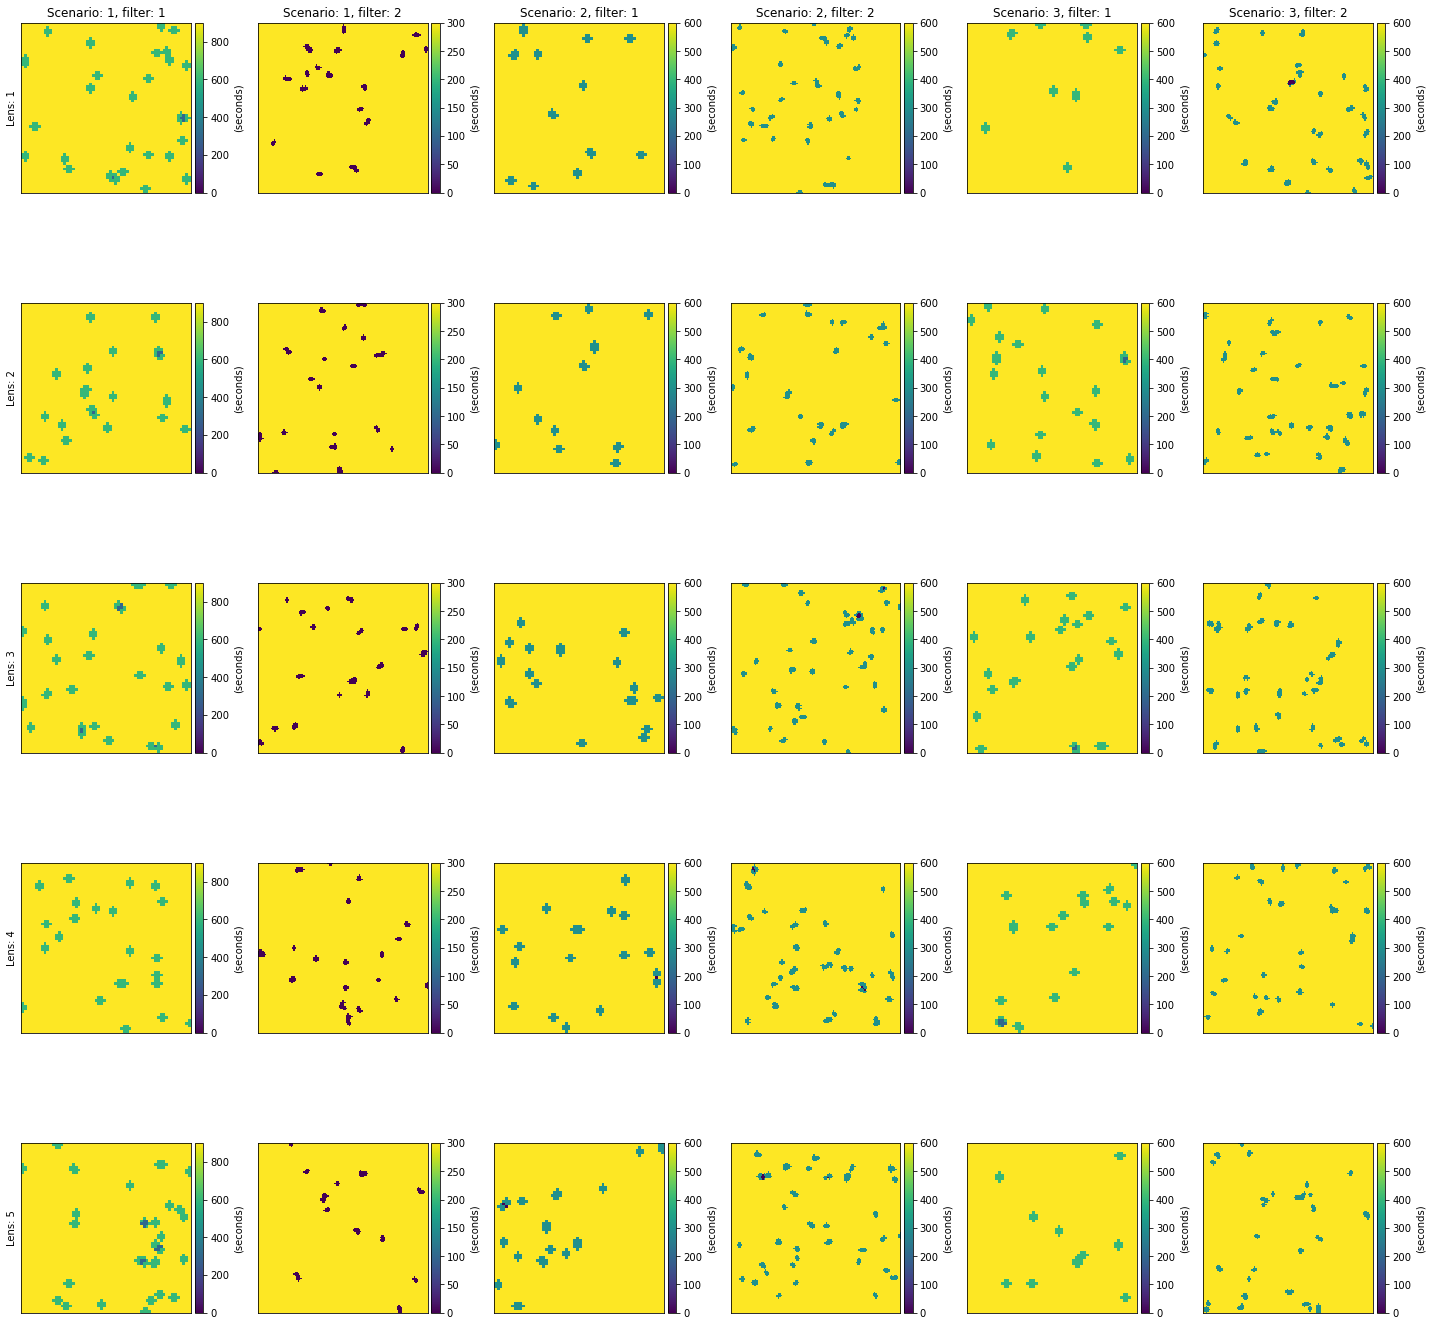

In [8]:
simulator.plot_exposure_maps(figsize=(20, 20))

In [9]:
simulator.fit_models(run_id='hst_snap', num_threads=8, n_run=700)

Running lens: 1/5, scenario: 1/3


100%|██████████| 700/700 [1:04:39<00:00,  5.54s/it]


Computing the MCMC...
Number of walkers =  128
Burn-in iterations:  0
Sampling iterations (in current run): 700
3887.978720188141 time taken for MCMC sampling
Running lens: 1/5, scenario: 2/3


100%|██████████| 700/700 [1:04:19<00:00,  5.51s/it]


Computing the MCMC...
Number of walkers =  128
Burn-in iterations:  0
Sampling iterations (in current run): 700
3866.400605916977 time taken for MCMC sampling
Running lens: 1/5, scenario: 3/3


100%|██████████| 700/700 [1:04:25<00:00,  5.52s/it]


Computing the MCMC...
Number of walkers =  128
Burn-in iterations:  0
Sampling iterations (in current run): 700
3873.8618426322937 time taken for MCMC sampling
Running lens: 2/5, scenario: 1/3


100%|██████████| 700/700 [1:05:45<00:00,  5.64s/it]


Computing the MCMC...
Number of walkers =  128
Burn-in iterations:  0
Sampling iterations (in current run): 700
3952.9717226028442 time taken for MCMC sampling
Running lens: 2/5, scenario: 2/3


100%|██████████| 700/700 [1:06:45<00:00,  5.72s/it]


Computing the MCMC...
Number of walkers =  128
Burn-in iterations:  0
Sampling iterations (in current run): 700
4013.2249734401703 time taken for MCMC sampling
Running lens: 2/5, scenario: 3/3


100%|██████████| 700/700 [1:05:18<00:00,  5.60s/it]


Computing the MCMC...
Number of walkers =  128
Burn-in iterations:  0
Sampling iterations (in current run): 700
3925.982199907303 time taken for MCMC sampling
Running lens: 3/5, scenario: 1/3


100%|██████████| 700/700 [1:04:03<00:00,  5.49s/it]


Computing the MCMC...
Number of walkers =  128
Burn-in iterations:  0
Sampling iterations (in current run): 700
3851.927912712097 time taken for MCMC sampling
Running lens: 3/5, scenario: 2/3


100%|██████████| 700/700 [1:06:44<00:00,  5.72s/it]


Computing the MCMC...
Number of walkers =  128
Burn-in iterations:  0
Sampling iterations (in current run): 700
4011.7741515636444 time taken for MCMC sampling
Running lens: 3/5, scenario: 3/3


100%|██████████| 700/700 [1:06:33<00:00,  5.71s/it]


Computing the MCMC...
Number of walkers =  128
Burn-in iterations:  0
Sampling iterations (in current run): 700
4001.247586965561 time taken for MCMC sampling
Running lens: 4/5, scenario: 1/3


100%|██████████| 700/700 [1:04:15<00:00,  5.51s/it]


Computing the MCMC...
Number of walkers =  128
Burn-in iterations:  0
Sampling iterations (in current run): 700
3863.058026075363 time taken for MCMC sampling
Running lens: 4/5, scenario: 2/3


100%|██████████| 700/700 [1:04:36<00:00,  5.54s/it]


Computing the MCMC...
Number of walkers =  128
Burn-in iterations:  0
Sampling iterations (in current run): 700
3885.1861321926117 time taken for MCMC sampling
Running lens: 4/5, scenario: 3/3


100%|██████████| 700/700 [1:06:43<00:00,  5.72s/it]


Computing the MCMC...
Number of walkers =  128
Burn-in iterations:  0
Sampling iterations (in current run): 700
4010.6721501350403 time taken for MCMC sampling
Running lens: 5/5, scenario: 1/3


100%|██████████| 700/700 [1:05:14<00:00,  5.59s/it]


Computing the MCMC...
Number of walkers =  128
Burn-in iterations:  0
Sampling iterations (in current run): 700
3922.058634519577 time taken for MCMC sampling
Running lens: 5/5, scenario: 2/3


100%|██████████| 700/700 [1:03:38<00:00,  5.46s/it]


Computing the MCMC...
Number of walkers =  128
Burn-in iterations:  0
Sampling iterations (in current run): 700
3827.124376296997 time taken for MCMC sampling
Running lens: 5/5, scenario: 3/3


100%|██████████| 700/700 [1:04:03<00:00,  5.49s/it]

Computing the MCMC...
Number of walkers =  128
Burn-in iterations:  0
Sampling iterations (in current run): 700
3852.9083111286163 time taken for MCMC sampling


-1.10756192656624 reduced X^2 of all evaluated imaging data combined.
reduced chi^2 of data  0 =  1.171739221434596
reduced chi^2 of data  1 =  1.0912087087345523


c:\mybin\lenstronomy\lenstronomy\Plots\plot_util.py:241: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("cubehelix").copy()
  cmap.set_bad(color='k', alpha=1.)
c:\mybin\lenstronomy\lenstronomy\Plots\plot_util.py:242: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("cubehelix").copy()
  cmap.set_under('k')
c:\mybin\lenstronomy\lenstronomy\Plots\model_band_plot.py:43: RuntimeWarning: divide by zero encountered in log10
  log_model = np.log10(model)
c:\mybin\lenstronomy\lenstronomy\Plots\model_band_plot.py:

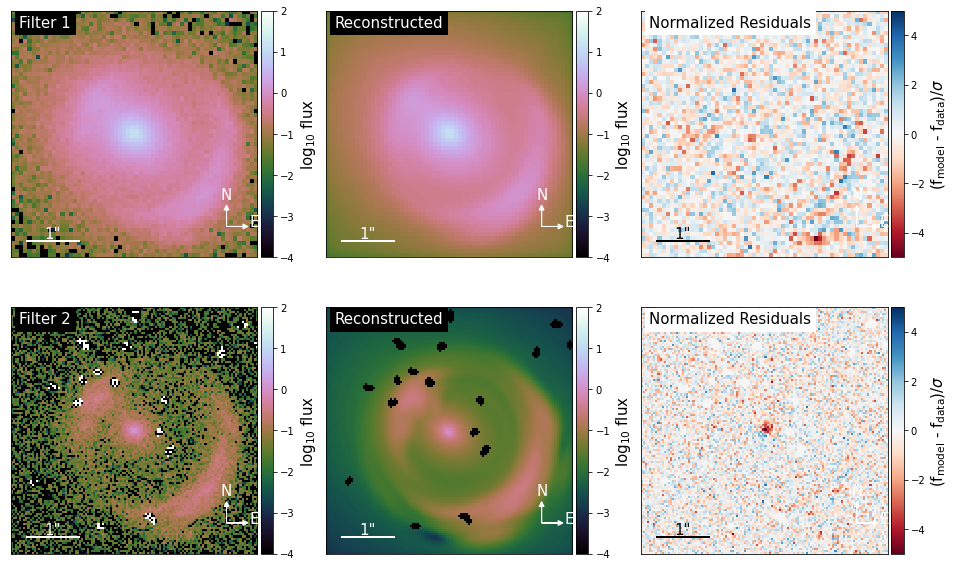

In [12]:
simulator.plot_model('hst_snap', 0, 0)

In [15]:
simulator.extend_chains(5, 3, 'hst_snap', 1, 8, 200)

Running lens: 1/5, scenario: 1/3
N_step: 700, N_walkers: 128, N_params: 16
re-using previous samples to initialize the next MCMC run.


100%|██████████| 200/200 [18:28<00:00,  5.54s/it]


Computing the MCMC...
Number of walkers =  128
Burn-in iterations:  0
Sampling iterations (in current run): 200
1115.8514609336853 time taken for MCMC sampling
Running lens: 1/5, scenario: 2/3
N_step: 700, N_walkers: 128, N_params: 16
re-using previous samples to initialize the next MCMC run.


100%|██████████| 200/200 [18:44<00:00,  5.62s/it]


Computing the MCMC...
Number of walkers =  128
Burn-in iterations:  0
Sampling iterations (in current run): 200
1132.7502310276031 time taken for MCMC sampling
Running lens: 1/5, scenario: 3/3
N_step: 700, N_walkers: 128, N_params: 16
re-using previous samples to initialize the next MCMC run.


100%|██████████| 200/200 [18:35<00:00,  5.58s/it]


Computing the MCMC...
Number of walkers =  128
Burn-in iterations:  0
Sampling iterations (in current run): 200
1124.1123836040497 time taken for MCMC sampling
Running lens: 2/5, scenario: 1/3
N_step: 700, N_walkers: 128, N_params: 16
re-using previous samples to initialize the next MCMC run.


100%|██████████| 200/200 [19:02<00:00,  5.71s/it]


Computing the MCMC...
Number of walkers =  128
Burn-in iterations:  0
Sampling iterations (in current run): 200
1151.0868921279907 time taken for MCMC sampling
Running lens: 2/5, scenario: 2/3
N_step: 700, N_walkers: 128, N_params: 16
re-using previous samples to initialize the next MCMC run.


100%|██████████| 200/200 [18:44<00:00,  5.62s/it]


Computing the MCMC...
Number of walkers =  128
Burn-in iterations:  0
Sampling iterations (in current run): 200
1132.5610597133636 time taken for MCMC sampling
Running lens: 2/5, scenario: 3/3
N_step: 700, N_walkers: 128, N_params: 16
re-using previous samples to initialize the next MCMC run.


100%|██████████| 200/200 [18:49<00:00,  5.65s/it]


Computing the MCMC...
Number of walkers =  128
Burn-in iterations:  0
Sampling iterations (in current run): 200
1137.530574798584 time taken for MCMC sampling
Running lens: 3/5, scenario: 1/3
N_step: 700, N_walkers: 128, N_params: 16
re-using previous samples to initialize the next MCMC run.


100%|██████████| 200/200 [19:00<00:00,  5.70s/it]


Computing the MCMC...
Number of walkers =  128
Burn-in iterations:  0
Sampling iterations (in current run): 200
1147.6607797145844 time taken for MCMC sampling
Running lens: 3/5, scenario: 2/3
N_step: 700, N_walkers: 128, N_params: 16
re-using previous samples to initialize the next MCMC run.


100%|██████████| 200/200 [18:23<00:00,  5.52s/it]


Computing the MCMC...
Number of walkers =  128
Burn-in iterations:  0
Sampling iterations (in current run): 200
1111.5579760074615 time taken for MCMC sampling
Running lens: 3/5, scenario: 3/3
N_step: 700, N_walkers: 128, N_params: 16
re-using previous samples to initialize the next MCMC run.


100%|██████████| 200/200 [17:53<00:00,  5.37s/it]


Computing the MCMC...
Number of walkers =  128
Burn-in iterations:  0
Sampling iterations (in current run): 200
1082.5876533985138 time taken for MCMC sampling
Running lens: 4/5, scenario: 1/3
N_step: 700, N_walkers: 128, N_params: 16
re-using previous samples to initialize the next MCMC run.


100%|██████████| 200/200 [18:42<00:00,  5.61s/it]


Computing the MCMC...
Number of walkers =  128
Burn-in iterations:  0
Sampling iterations (in current run): 200
1130.0567843914032 time taken for MCMC sampling
Running lens: 4/5, scenario: 2/3
N_step: 700, N_walkers: 128, N_params: 16
re-using previous samples to initialize the next MCMC run.


100%|██████████| 200/200 [18:52<00:00,  5.66s/it]


Computing the MCMC...
Number of walkers =  128
Burn-in iterations:  0
Sampling iterations (in current run): 200
1140.229026556015 time taken for MCMC sampling
Running lens: 4/5, scenario: 3/3
N_step: 700, N_walkers: 128, N_params: 16
re-using previous samples to initialize the next MCMC run.


100%|██████████| 200/200 [19:00<00:00,  5.70s/it]


Computing the MCMC...
Number of walkers =  128
Burn-in iterations:  0
Sampling iterations (in current run): 200
1149.174154996872 time taken for MCMC sampling
Running lens: 5/5, scenario: 1/3
N_step: 700, N_walkers: 128, N_params: 16
re-using previous samples to initialize the next MCMC run.


100%|██████████| 200/200 [17:22<00:00,  5.21s/it]


Computing the MCMC...
Number of walkers =  128
Burn-in iterations:  0
Sampling iterations (in current run): 200
1049.9580054283142 time taken for MCMC sampling
Running lens: 5/5, scenario: 2/3
N_step: 700, N_walkers: 128, N_params: 16
re-using previous samples to initialize the next MCMC run.


100%|██████████| 200/200 [17:44<00:00,  5.32s/it]


Computing the MCMC...
Number of walkers =  128
Burn-in iterations:  0
Sampling iterations (in current run): 200
1072.6976673603058 time taken for MCMC sampling
Running lens: 5/5, scenario: 3/3
N_step: 700, N_walkers: 128, N_params: 16
re-using previous samples to initialize the next MCMC run.


100%|██████████| 200/200 [17:31<00:00,  5.26s/it]

Computing the MCMC...
Number of walkers =  128
Burn-in iterations:  0
Sampling iterations (in current run): 200
1059.1553626060486 time taken for MCMC sampling


N_step: 700, N_walkers: 128, N_params: 16
theta_E_lens0 1.3861 ± 0.0020
gamma_lens0 1.9772 ± 0.0181
e1_lens0 0.0628 ± 0.0046
e2_lens0 -0.1052 ± 0.0062
gamma1_lens1 0.0429 ± 0.0027
gamma2_lens1 -0.0388 ± 0.0042
beta_source_light0 0.1457 ± 0.0026
center_x_source_light0 0.2788 ± 0.0077
center_y_source_light0 -0.2947 ± 0.0071
R_sersic_lens_light0 1.3525 ± 0.0381
n_sersic_lens_light0 4.7036 ± 0.0745
e1_lens_light0 0.0814 ± 0.0026
e2_lens_light0 -0.1109 ± 0.0028
center_x_lens_light0 -0.0365 ± 0.0006
center_y_lens_light0 -0.0364 ± 0.0005
R_sersic_lens_light1 1.7752 ± 0.0932


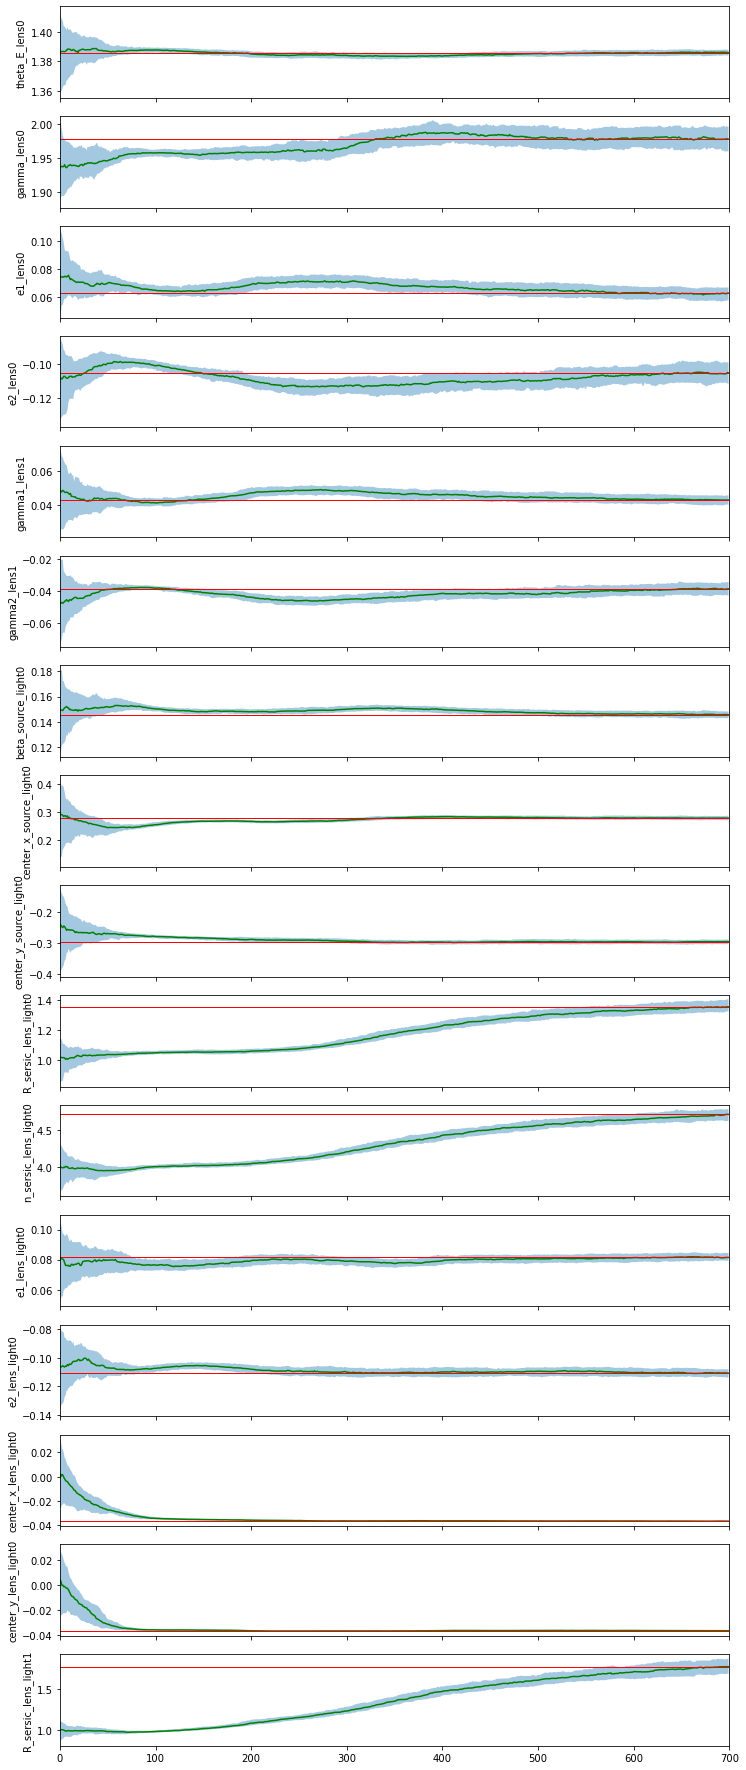

In [14]:
simulator.plot_mcmc_trace('hst_snap', 0, 2)